<style type="text/css">
* {
     max-width: 1000px;
}

body {
    margin: 0 auto
}

.column {
  float: left;
  width: 33.33%;
}

/* Clear floats after the columns */
.row:after {
  content: "";
  display: table;
  clear: both;
}


.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

h2 {
    page-break-before: always;
}

.code_cell {
    page-break-inside: avoid;
}
</style>

# Verkefni II

### Motion Control in Computer-Aided Modeling

##### Reality Check 5, Numerical Analysis 2nd ed., Sauer.
<hr>

#### Erling Óskar Kristjánsson, eok4@hi.is

#### Davíð Freyr Björnsson, dfb2@hi.is
<hr>

##### Námskeið: Töluleg Greining (Stæ405G)

##### Stofnun: Háskóli Íslands

##### Umsjónamaður: Sigurður Freyr Hafstein

##### Vor 2019
<hr>

<h2 style="page-break-before: avoid"> Introduction </h2>

Computer-aided modeling and manufacturing requires precise control of spatial position
along a prescribed motion path. We will illustrate the use of Adaptive Quadrature to solve
a fundamental piece of the problem: equipartition, or the division of an arbitrary path into
equal-length subpaths.

In numerical machining problems, it is preferable to maintain constant speed along the
path. During each second, progress should be made along an equal length of the machine–
material interface. In other motion planning applications, including computer animation,
more complicated progress curves may be required: A hand reaching for a doorknob might 
begin and end with low velocity and have higher velocity in between. Robotics and virtual
reality applications require the construction of parametrized curves and surfaces to be
navigated. Building a table of small equal increments in path distance is often a necessary
first step.

Assume that a parametric path P = $\{x(t),\ y(t) \ | \  0 \leq t \leq 1\}$ is given. Figure 5.6 shows
the example path

$$
P =
\begin{cases}
x(t) = 0.5 + 0.3t + 3.9t^2 − 4.7t^3, \\
y(t) = 1.5 + 0.3t + 0.9t^2 − 2.7t^3
\end{cases}
$$

Bézier curve defined by the four points $(0.5,1.5)$, $(0.6,1.6)$, $(2,2)$, $(0,0)$. 
Points defined by evenly spaced parameter values $t = 0, 1/4, 1/2, 3/4, 1$ are shown. 

![(May need to host pictures like this online and supply a https link) Figure 5.6](img/Figure5_6.JPG)

Note that even spacing in parameter does not imply even spacing in arc length. 
Your goal is to apply quadrature methods to divide this path into $n$ equal lengths.

Recall from calculus that the arc length of the path from $t_1$ to $t_2$ is

$$
\int_{t_1}^{t_2} \sqrt{x'(t)^2+y'(t)^2}dt
$$

Only rarely does the integral yield a closed-form expression, and normally an Adaptive
Quadrature technique is used to control the parametrization of the path.

<hr>

## Preliminaries

Commence by defining global imports, the given parametric function and its curve, as well as 
a global tolerance and the number of decimal places that will be specified throughout the project.

In [1]:
""" Global Imports """
# Plots and animation
import matplotlib
from matplotlib.backends.backend_agg import FigureCanvasAgg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from celluloid import Camera
import matplotlib.pyplot as plt

from functionsV2 import * # Project Functions. See Appendix.

from time import perf_counter # For timing
import numpy as np
from random import uniform

In [2]:
tol = 0.5e-5 # Temporary global tol
dec = 5 # Temporary global number of decimals

# The given parametric equation
x = lambda t: 0.5 + 0.3*t + 3.9*t**2 - 4.7*t**3
y = lambda t: 1.5 + 0.3*t + 0.9*t**2 - 2.7*t**3

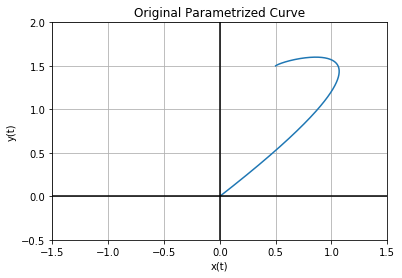

In [3]:
""" Plot of the given parametric path """
plotParameterizedCurves(x,y,[0,1],1,"Original Parametrized Curve")

<hr>

## Suggested Activity 1

Write a Python function that uses Adaptive Quadrature to compute the arc length from $t_1 = 0$ to $t_2 = T$ for a given $T \leq 1$.

- The given parametric equation $P(x(t),y(t))$ was differentiated manually.

In [4]:
""" Suggested Activity 1 """
# Manually computed derivatives of the given parametric path
dxdt = lambda t: 0.3 + 7.8*t - 14.1*t**2
dydt = lambda t: 0.3 + 1.8*t - 8.1*t**2

# Compute the lambda function that is to be integrated
f = sqrtFunSquared(dxdt, dydt)

# Compute the corresponding arc length
# by computing the integral of f from
# 0 to 1 using the method of Adaptive Quadrature
arcLength = compArcLength(f, 0.0, 1.0, adQuad, tol)

print("The arc length is", round(arcLength, dec))

The arc length is 2.49525


<hr>

## Suggested Activity 2

Write a program that, for any input $s$ between $0$ and $1$, finds the parameter $t^∗(s)$
that is $s$ of the way along the curve. In other words, the arc length from $t = 0$
to $t = t^∗(s)$ divided by the arc length from $t = 0$ to $t = 1$ should be equal to $s$.

**In other other words:**

$$ s = \frac{\int_{0}^{t^*(s)} \sqrt{x'(t)^2+y'(t)^2}dt}{ \int_{0}^{1} \sqrt{x'(t)^2+y'(t)^2}dt}$$

Use the Bisection Method to locate the point $t^∗(s)$ to three correct decimal places. 

1. What function is being set to zero?<br>
$$s \int_{0}^{1} \sqrt{x'(t)^2+y'(t)^2}dt - \int_{0}^{t^*(s)} \sqrt{x'(t)^2+y'(t)^2}dt$$
2. What bracketing interval should be used to start the Bisection Method?<br>
The bracket interval [0, 1], since for $t^*(s) = 0$ it follows that $s=0$ and when $t^*(s) = 1$ it follows that $s=1$. So this range of $t^*(s)$ covers all the possible values of $s$.

In [5]:
""" Suggested Activity 2 """
# The function tStarOfSBisect takes the argument s
# (s is between 0 and 1) and finds the parameter t*(s).
# Let's time the function tStarOfSBisect for s = 0.5 
s = 0.5
start = perf_counter()
tStar2 = tStarOfSBisect(f, s, adQuad, tol)
end = perf_counter()
elapsedTime2 = end - start

print('The optimal value of t for s =', round(s, dec), 'is', round(tStar2, dec))
print('and was computed in', round(elapsedTime2, dec), 'seconds')

# Let's verify if tStar really is the root of the function 
print('Which is the root within our tolerance:', 
      (np.abs(compArcLength(f, 0.0, tStar2, adQuad, tol) / 
                           arcLength - s) < 2*tol))

The optimal value of t for s = 0.5 is 0.80059
and was computed in 0.17312 seconds
Which is the root within our tolerance: True


<hr>

## Suggested Activity 3

Equipartition (_split into parts of equal length_) the path of Figure 5.6 into $n$ subpaths of equal length, for $n = 4$ and $n = 20$. Plot analogues of Figure 5.6, showing the equipartitions. If your computations are too slow, consider speeding up the Adaptive Quadrature with Simpson’s Rule, as suggested in Computer Problem 5.4.2.

- We use the methodology from the previous example. First we implement an efficient version of the Adaptive Quadrature with Simpson's Rule, shown below. This change speeds up the computations considerably.

Let us consider the scenario where $n = 4$: 
- We know that the length of the curve is approximately $2.49525$, so in this scenario we want each part to be of length $0.62381$.

In [6]:
""" Suggested Activity 3 """
# For n = 4
sArray_n4 = [0.0, 0.25, 0.5, 0.75, 1.0]
n = 4
tStarArray = np.zeros(n+1)
start = perf_counter()
for i in range(n):
    tStarArray[i+1] = tStarOfSBisect(f, sArray_n4[i+1], adQuadSimpson, tol)
end = perf_counter()
elapsedTime3n4 = end - start
print("For n = 4 the computation of t*(s) took",
      round(elapsedTime3n4, dec), "seconds using Simpson's Rule and the Bisection method")

for i in range(n): # let's verify that each arclength is about a quarter of the length of the path
    partialArclength = compArcLength(f, tStarArray[i], tStarArray[i+1], adQuadSimpson, tol)
    if abs(partialArclength / arcLength - 1/n) > 10*tol:
        print('Arc length from', round(tStarArray[i], dec), end=' ')
        print('to', round(tStarArray[i+1], dec), end=' ') 
        print('is', round(partialArclength, dec))
        print('Proportional arc length:',
              round(np.abs(partialArclength / arcLength), dec))

For n = 4 the computation of t*(s) took 0.01876 seconds using Simpson's Rule and the Bisection method


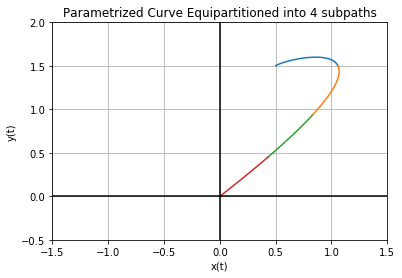

In [7]:
# Plot the equipartitioned subpaths on one graph but in different colors
plotParameterizedCurves(x,y,tStarArray,n,"Parametrized Curve Equipartitioned into 4 subpaths")

Let us then consider the scenario where $n = 20$: 
- We know that the length of the curve is approximately $2.49525$, so in this scenario we want each part to be of length $0.12476$.

In [8]:
# For n = 20
sArray_n20 = np.arange(0.00, 1.05, 0.05)
n = 20
tStarArray = np.zeros(n+1)
start = perf_counter()
for i in range(n):
    tStarArray[i+1] = tStarOfSBisect(f, sArray_n20[i+1], adQuadSimpson, tol)
end = perf_counter()
elapsedTime3n20 = end - start
print("For n=20 the computation of t*(s) program took", 
      round(elapsedTime3n20, dec), "seconds using Simpson's Rule and the Bisection method")

for i in range(n): # let's verify that each arclength is about one-twentieth of the length of the path
    partialArclength = compArcLength(f, tStarArray[i], tStarArray[i+1], adQuadSimpson, tol)
    if abs(partialArclength / arcLength - 1/n) > 10*tol:
        print('Arc length from', round(tStarArray[i], dec), end=' ')
        print('to', round(tStarArray[i+1], dec), end=' ') 
        print('is', round(partialArclength, dec))
        print('Proportional arc length:',
              round(np.abs(partialArclength / arcLength), dec))

For n=20 the computation of t*(s) program took 0.08827 seconds using Simpson's Rule and the Bisection method


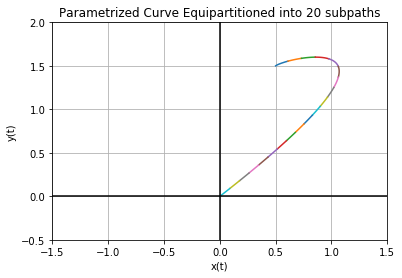

In [9]:
# Plot the equipartitioned subpaths on one graph but in different colors
plotParameterizedCurves(x,y,tStarArray,n,"Parametrized Curve Equipartitioned into 20 subpaths")

<hr>

## Suggested Activity 4

Replace the Bisection Method in Step 2 with Newton’s Method, and repeat Steps 2 and 3.

1. What is the derivative needed? <br>

The derivative with respect to $t$ of the function that is being set to zero, namely $$ d \bigg( s \int_{0}^{1} \sqrt{x'(t)^2+y'(t)^2}dt - \int_{0}^{t^*(s)} \sqrt{x'(t)^2+y'(t)^2}dt \bigg) dt^{-1} $$
The derivative can be estimated in the necessary points using Python's `Autograd`. However, a loop of trials revealed that the Three-point centered-difference formula described in Chapter 5.1 gave the same estimates as `Autograd` to at least five decimal places, so that will be used instead.
2. What is a good choice for the initial guess? <br>

As in Suggested Activity 2, it is clear that the root lies in the interval $[0,1]$. When repeating Suggest Activity 2, it makes sense to use the value of $t^*(s)$ that was computed earlier as an initial guess. That makes Newton's method converge much faster than the Bisection method, as shown below. However, this is an unfair comparison. More precision is however possible when the  path is being equipartitioned into $n$ parts. When diving the path into $n$ paths of equal length, one can use the initial guess of $0$ for the first $t^*(s)$, and then one can use that $t^*(s)$ as an initial guess for the next $t^*(s)$, and so on.

3. Is computation time decreased by this replacement? <br>

Apparently the initial guess for Newton's method has quite an effect on the time it takes to converge. Our tests showed no clear sign of one method generally being faster than the other, unless the initial guess is extraordinarily good. When performing large-scale computations, it might be good to perform a few iterations of the Bisection method first to get a decent estimate of a starting point for Newton's method, and then proceed from there with Newton's method.

In [10]:
""" Suggested Activity 4 """
start = perf_counter() # Newt takes 12 times longer with initial guess of 0.0 than with 0.8
tStar4 = tStarOfSNewton(f, s, adQuad, 0.8, tol)
end = perf_counter()
elapsedTime4 = end - start

print('The computed value of t*(s) for s =', s, end=' ')
print('using Newton\'s method is', round(tStar4, dec+3))

print('The computed value of t*(s) for s =', s, end=' ')
print('using the Bisection method is', round(tStar2, dec+3))
print('Which is the same within our tolerance:', abs(tStar4-tStar2)<tol, "\n")

print('Time required to compute t*(s) using the Newton\'s method is:',
            round(elapsedTime4, dec+2), "seconds")
print('Time required to compute t*(s) using the Bisection method is:',
            round(elapsedTime2, dec+2), "seconds")

The computed value of t*(s) for s = 0.5 using Newton's method is 0.80059404
The computed value of t*(s) for s = 0.5 using the Bisection method is 0.80059052
Which is the same within our tolerance: True 

Time required to compute t*(s) using the Newton's method is: 0.0876078 seconds
Time required to compute t*(s) using the Bisection method is: 0.1731189 seconds


In [11]:
# For n = 4
n = 4
tStarArray = np.zeros(n+1)
start = perf_counter()
for i in range(n):
    tStarArray[i+1] = tStarOfSNewton(f, sArray_n4[i+1], adQuadSimpson, tStarArray[i], tol)
end = perf_counter()
elapsedTime4n4 = end - start
print("For n = 4, using Newton's method, the computation of t*(s) took",
      round(elapsedTime4n4, dec), "seconds")
print("For n = 4, using the Bisection method, the computation of t*(s) took",
      round(elapsedTime3n4, dec), "seconds")

for i in range(n): # let's verify that each arclength is about a quarter of the length of the path
    partialArclength = compArcLength(f, tStarArray[i], tStarArray[i+1], adQuadSimpson, tol)
    if abs(partialArclength / arcLength - 1/n) > 10*tol:
        print('Arc length from', round(tStarArray[i], dec), end=' ')
        print('to', round(tStarArray[i+1], dec), end=' ') 
        print('is', round(partialArclength, dec))
        print('Proportional arc length:',
              round(np.abs(partialArclength / arcLength), dec))

For n = 4, using Newton's method, the computation of t*(s) took 0.03358 seconds
For n = 4, using the Bisection method, the computation of t*(s) took 0.01876 seconds


In [12]:
# For n = 20
n = 20
tStarArray = np.zeros(n+1)
start = perf_counter()
for i in range(n):
    tStarArray[i+1] = tStarOfSNewton(f, sArray_n20[i+1], adQuadSimpson, tStarArray[i], tol)
end = perf_counter()
elapsedTime4n20 = end - start
print("For n = 20, using Newton's method, the computation of t*(s) took",
      round(elapsedTime4n20, dec), "seconds")
print("For n = 20, using the Bisection method, the computation of t*(s) took",
      round(elapsedTime3n20, dec), "seconds")


for i in range(n): # let's verify that each arclength is about one-twentieth of the length of the path
    partialArclength = compArcLength(f, tStarArray[i], tStarArray[i+1], adQuadSimpson, tol)
    if abs(partialArclength / arcLength - 1/n) > 10*tol:
        print('Arc length from', round(tStarArray[i], dec), end=' ')
        print('to', round(tStarArray[i+1], dec), end=' ') 
        print('is', round(partialArclength, dec))
        print('Proportional arc length:',
              round(np.abs(partialArclength / arcLength), dec))

For n = 20, using Newton's method, the computation of t*(s) took 0.08905 seconds
For n = 20, using the Bisection method, the computation of t*(s) took 0.08827 seconds


<hr>

## Suggested Activity 5

Use animation commands to demonstrate traveling along the path, first at the original parameter $0 \leq t \leq 1$ speed and then at the (constant) speed given by $t^∗(s)$ for $0 \leq s \leq 1$.

- In the first animation the particle accelerate towards the end of the path.
- In the second animation the particle moves at a constant speed.

In [13]:
animateBezierCurve(x, y, np.arange(0.0,1.05,0.05),
                   "Traveling at speed with intervals $dt=0.05$ from $t=0$ to $t=1$")

In [14]:
animateBezierCurve(x, y, tStarArray,
                   "Traveling at constant speed given by t*(s)")

<hr>

## Suggested Activity 6

Experiment with equipartitioning a path of your choice. Build a design, initial, etc. of your choice out of Bézier curves, partition it into equal arc length segments, and animate as in Step 5.

 - Functions were designed to randomly generate a specified number of Bézier curves in the area $[-1.5,1.5] \times [-0.5,2.0] \in \mathbb{R}^{2\times2}$.
 - The parametric equations that represent these Bézier curves are differentiated symbolically using *Python SymPy*.
 - These derivatives are turned into lambda expressions.
 - The length of each arc is printed.
 - These randomly generated paths are then equipartitioned into $n=20$ subpaths each.
 - The subpaths are plotted and their plots are saved for display.

In [38]:
""" Suggested Activity 6 """
n_BezierCurves = 3
BezierCurves, DerivBezierCurves = bezierCurves(n_BezierCurves)

n = 20 # Equipartition each BezierCurve into 20 subpaths
tStarArrays = [np.zeros(n+1),np.zeros(n+1),np.zeros(n+1)]
for j in range(n_BezierCurves):
    random_f = sqrtFunSquared(DerivBezierCurves[j][0], DerivBezierCurves[j][1])
    random_arcLength = compArcLength(random_f, 0.0, 1.0, adQuadSimpson, tol)
    print('The arc length of random bezier curve number', j+1, 'is', random_arcLength)
    for i in range(n):
        tStarArrays[j][i+1] = tStarOfSNewton(random_f, sArray_n20[i+1], adQuadSimpson, tStarArrays[j][i], tol)
# Verify that each arclength is about one-twentieth of the length of the path
        partialArclength = compArcLength(random_f, tStarArrays[j][i], tStarArrays[j][i+1], adQuadSimpson, tol)
        if abs(partialArclength / random_arcLength - 1/n) > 10*tol:
            print('Arc length from', round(tStarArrays[j][i], dec), end=' ')
            print('to', round(tStarArrays[j][i+1], dec), end=' ') 
            print('is', round(partialArclength, dec))
            print('Proportional arc length:',
                  round(np.abs(partialArclength / random_arcLength), dec))
    plotParameterizedCurves(BezierCurves[j][0],BezierCurves[j][1], tStarArrays[j], n,
                            "Parametrized Curve Equipartitioned into 20 subpaths",
                            "RandomBezierCurveEquipartitioned"+str(j))

The arc length of random bezier curve number 1 is 3.028739659774228
The arc length of random bezier curve number 2 is 1.9090478629072587
Arc length from 0.95149 to 0.96888 is 0.09561
Proportional arc length: 0.05008
Arc length from 0.96888 to 0.98495 is 0.09529
Proportional arc length: 0.04991
The arc length of random bezier curve number 3 is 3.6016943125527723


<div class="row">
    <img src="img/RandomBezierCurveEquipartitioned0.PNG" class="column">
    <img src="img/RandomBezierCurveEquipartitioned1.PNG" class="column">
    <img src="img/RandomBezierCurveEquipartitioned2.PNG" class="column">
</div>

- Data is ready. Finally **Suggested Activity 5** can be repeated for for these randomly generate Bezier curves.

In [39]:
animateBezierCurve(BezierCurves[0][0], BezierCurves[0][1], np.arange(0.0,1.05,0.05),
                       "Traveling at speed with intervals $dt=0.05$ from $t=0$ to $t=1$")

In [40]:
animateBezierCurve(BezierCurves[0][0], BezierCurves[0][1], tStarArrays[0],
                       "Traveling at constant speed given by t*(s)")

In [41]:
animateBezierCurve(BezierCurves[1][0], BezierCurves[1][1], np.arange(0.0,1.05,0.05),
                       "Traveling at speed with intervals $dt=0.05$ from $t=0$ to $t=1$")

In [42]:
animateBezierCurve(BezierCurves[1][0], BezierCurves[1][1], tStarArrays[1],
                       "Traveling at constant speed given by t*(s)")

In [43]:
animateBezierCurve(BezierCurves[2][0], BezierCurves[2][1], np.arange(0.0,1.05,0.05),
                       "Traveling at speed with intervals $dt=0.05$ from $t=0$ to $t=1$")

In [44]:
animateBezierCurve(BezierCurves[2][0], BezierCurves[2][1], tStarArrays[2],
                       "Traveling at constant speed given by t*(s)")

<hr>

## Suggested Activity 7

Write a program that traverses the path P according to an arbitrary progress curve $C(s), 0 ≤ s ≤ 1$, with $C(0) = 0$ and $C(1) = 1$. The object is to move along the curve $C$ in such a way that the proportion $C(s)$ of the path’s total arc length is traversed between $0$ and $s$. For example, constant speed along the path would be represented by $C(s) = s$.

Try progress curves $C(s) = s^{1/3}$, $C(s) = s^2$, $C(s) = sin(s\pi/2)$, for example.

- Spread $s$ from $0$ to $1$ into $20$ points where each point is $C(s)$.
- Plot the paths according to each partition.
- Animate the movement of a particle along the curve at the speed generated by $C(s)$.

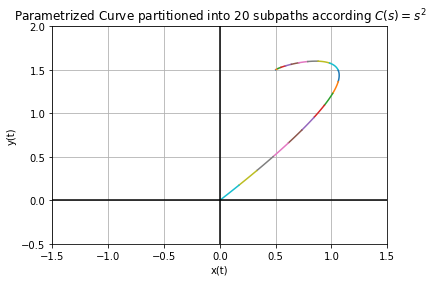

In [22]:
# C(s)=s^2
n = 20
sSquaredArray_n20 = [s**2 for s in sArray_n20]
tStarArray = np.zeros(n+1)
for i in range(n):
    tStarArray[i+1] = tStarOfSNewton(f, sSquaredArray_n20[i+1], adQuadSimpson, tStarArray[i], tol)

for i in range(n): # let's verify that NONE of the arclengths is about one-twentieth of the length of the path
    partialArclength = compArcLength(f, tStarArray[i], tStarArray[i+1], adQuadSimpson, tol)
    if not abs(partialArclength / arcLength - 1/n) > 10*tol:
        print('Arc length from', round(tStarArray[i], dec), end=' ')
        print('to', round(tStarArray[i+1], dec), end=' ') 
        print('is', round(partialArclength, dec))
        print('Proportional arc length:',
              round(np.abs(partialArclength / arcLength), dec))

plotParameterizedCurves(x,y,tStarArray,n,"Parametrized Curve partitioned into 20 subpaths according $C(s)=s^2$")

In [23]:
animateBezierCurve(x, y, tStarArray,
                   "Traveling at varied speed given by $C(s)=s^2$")

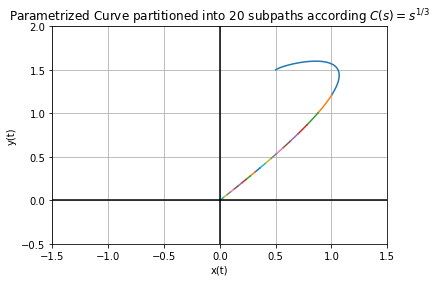

In [24]:
# C(s)=s^(1/3)
n = 20
sPowOneThirdArray_n20 = [s**(1/3) for s in sArray_n20]
tStarArray = np.zeros(n+1)
for i in range(n):
    tStarArray[i+1] = tStarOfSNewton(f, sPowOneThirdArray_n20[i+1], adQuadSimpson, tStarArray[i], tol)

for i in range(n): # let's verify that NONE of the arclengths is about one-twentieth of the length of the path
    partialArclength = compArcLength(f, tStarArray[i], tStarArray[i+1], adQuadSimpson, tol)
    if not abs(partialArclength / arcLength - 1/n) > 10*tol:
        print('Arc length from', round(tStarArray[i], dec), end=' ')
        print('to', round(tStarArray[i+1], dec), end=' ') 
        print('is', round(partialArclength, dec))
        print('Proportional arc length:',
              round(np.abs(partialArclength / arcLength), dec))

plotParameterizedCurves(x,y,tStarArray,n,"Parametrized Curve partitioned into 20 subpaths according $C(s)=s^{1/3}$")

In [25]:
animateBezierCurve(x, y, tStarArray,
                   "Traveling at varied speed given by $C(s)=s^{1/3}$")

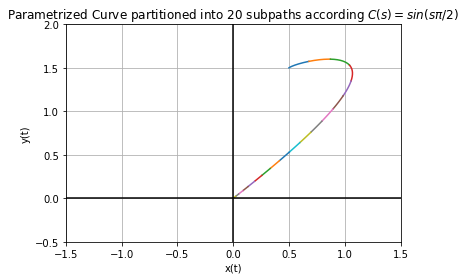

In [26]:
# C(s) = sin(s\pi/2)
n = 20
sSinArray_n20 = [np.sin(s*np.pi/2) for s in sArray_n20]
tStarArray = np.zeros(n+1)
for i in range(n):
    tStarArray[i+1] = tStarOfSNewton(f, sSinArray_n20[i+1], adQuadSimpson, tStarArray[i], tol)

for i in range(n): # let's verify that NONE of the arclengths is about one-twentieth of the length of the path
    partialArclength = compArcLength(f, tStarArray[i], tStarArray[i+1], adQuadSimpson, tol)
    if not abs(partialArclength / arcLength - 1/n) > 10*tol:
        print('Arc length from', round(tStarArray[i], dec), end=' ')
        print('to', round(tStarArray[i+1], dec), end=' ') 
        print('is', round(partialArclength, dec))
        print('Proportional arc length:',
              round(np.abs(partialArclength / arcLength), dec))

plotParameterizedCurves(x,y,tStarArray,n,"Parametrized Curve partitioned into 20 subpaths according $C(s) = sin(s\pi/2)$")

In [27]:
animateBezierCurve(x, y, tStarArray,
                   "Traveling at varied speed given by $C(s)=sin(s\pi/2)$")

<hr>

## Appendix

#### functionsV2.py

```Python
""" Global Imports """
# Plots and animation
import matplotlib
from matplotlib.backends.backend_agg import FigureCanvasAgg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from celluloid import Camera
import matplotlib.pyplot as plt

from time import perf_counter
import numpy as np
from random import uniform

from sympy.core import sympify
from sympy.utilities import lambdify
from sympy import symbols, diff

    
""" Plots many sections of a curve on one plot """
def plotParameterizedCurves(x, y, ts, n, header, save=None):
    fig, axis = plt.subplots()
    for i in range(n):
        t = np.arange(ts[i], ts[i+1], 0.001)
        axis.plot(x(t), y(t))
    axis.set(xlabel='x(t)', ylabel='y(t)',title=header)
    plt.yticks(np.arange(-0.5,2.5,0.5))
    plt.xticks(np.arange(-1.5,2.0,0.5))
    axis.axhline(y=0, color='k')
    axis.axvline(x=0, color='k')
    axis.grid()
    if save is not None:
        fig.savefig('img/'+save+'.PNG')
        plt.close()


""" SA 1 """
# Returns the lamda function sqrt(dxdt(t)^2 + dydt(t)^2)
# given dxdt(t) and dydt(t)
def sqrtFunSquared(dxdt, dydt):
    return lambda t: np.sqrt(dxdt(t)**2 + dydt(t)**2)

# Computes the arc length for a given function (f)
# and tolerance (tol), from t = 0 to t = T
# with a given method of integration. 
def compArcLength(f, t, T, intMethod, tol):
    return intMethod(f, t, T, tol)

# Computes the definite integral of a given function (f)
# from a to b using the method of Adaptive Quadrature
def adQuad(f, a, b, tol):
    c = (a+b)/2
    h = b-a
    S_ab = (h/2)*(f(a)+f(b))
    S_ac = (h/4)*(f(a)+f(c))
    S_cb = (h/4)*(f(c)+f(b))
    if np.abs(S_ab - S_cb - S_ac) < 3*tol: #  and h < 1e-2
        return (S_ac + S_cb)
    else:
        return (adQuad(f, a, c, tol/2) + adQuad(f, c, b, tol/2))

# Returns a function that approximates of the derivative of f(x)
# at x = a
def threePointCentDiff(f, h=1e-5):
    return lambda a: (f(a+h) - f(a-h))/(2*h)
```

```Python
""" SA 2 """
# Usage:    BisectionMethod(f,a,b)
# Pre:      f is a continuous fucntion on the interval [a,b]
#           a < b are numbers such that f(a)*f(b) < 0
#           tol is a number
# Post:     c is the root of f, i.e f(c) = 0
def bisectionMethod(f,a,b,tol):
    fa=f(a)
    fb=f(b)
    while (b-a)/2 > tol:
        c=(a+b)/2
        fc=f(c)
        if fa*fc <= 0:
            b=c
            fb=fc
        else:
            a=c
            fa=fc
    return c

# intMethod: Integration Method
def tStarOfSBisect(f, s, intMethod, tol):
    a = compArcLength(f, 0.0, 1.0, intMethod, tol)
    g = lambda b: (s * a - compArcLength(f, 0.0, b, intMethod, tol))
    return bisectionMethod(g, 0.0, 1.0, tol)

""" SA 3 """
def simpsonsRule(f, a, b):
    h = (b-a)/6
    c = (a+b)/2
    return (c, h * (f(a) + 4 * f(c) + f(b)))

def adQuadSimpson(f, a, b, tol, c=0):
    c, sab = simpsonsRule(f, a, b)
    lc, sac  = simpsonsRule(f, a, c)
    rc, scb = simpsonsRule(f, c, b)
    if abs(sab - sac - scb) < 15*tol: #  and h < 1e-1
        return sac + scb
    return (adQuadSimpson(f, a, c, tol, lc) +
           adQuadSimpson(f, c, b, tol, rc))
    
""" SA 4 """

def newtonsMethod(f, xold, tol):
#    start = perf_counter()
    dfdt = threePointCentDiff(f)
    xnew = xold - f(xold)/dfdt(xold)
    while abs(xnew-xold) > tol:
        xold = xnew
        xnew = xold - f(xold)/dfdt(xold)
#    end = perf_counter()
#    print('it took', end-start, 'time to compute', xnew)
    return xnew

def tStarOfSNewton(f, s, intMethod, xold, tol):
    a = compArcLength(f, 0.0, 1.0, intMethod, tol)
    g = lambda b: (s * a - compArcLength(f, 0.0, b, intMethod, tol))
    return newtonsMethod(g, xold, tol)
```

```Python
""" SA 5 """
# Animates a particle traveling along the path represented by
# function x(t) and y(t)
def animateBezierCurve(x,y,ts,header):
    rc('animation', html='jshtml')
    fig = plt.figure()
    plt.close()
    axis = fig.gca()
    axis.set(xlabel='x(t)', ylabel='y(t)',title=header,)
    axis.set_xticks(np.arange(-1.5,2.0,0.5))
    axis.set_yticks(np.arange(-0.5,2.5,0.5))
    cam = Camera(fig)
    zeroToOne = np.arange(0, 1.01, 0.01)
    for t in ts:
        axis.plot(x(zeroToOne), y(zeroToOne),color='red')
        axis.plot(x(t),y(t), 'bo', color='blue')
        axis.axhline(y=0, color='k')
        axis.axvline(x=0, color='k')
        cam.snap()
    anim = cam.animate(blit=False, interval=100)
    return anim



""" SA 6 """
# Points: List of points (x,y)
# Initial point is: x0 = Points[0][0] and y0 = Points[0][1]
# End point is: x3 = Points[3][0] and y3 = [3][1]
# Control points in between
# Also returns string representation of them
def bezierCurve(Points):
    bx = round(3*(Points[1][0] - Points[0][0]),2)
    cx = round(3*(Points[2][0] - Points[1][0]) - bx,2)
    dx = round(Points[3][0] - Points[0][0] - bx - cx,2)
    by = round(3*(Points[1][1] - Points[0][1]),2)
    cy = round(3*(Points[2][1] - Points[1][1]) - by,2)
    dy = round(Points[3][1] - Points[0][1] - by - cy,2)
    x = lambda t: Points[0][0] + bx*t + cx*t**2 + dx*t**3
    y = lambda t: Points[0][1] + by*t + cy*t**2 + dy*t**3
    xExpr = sympify(str(Points[0][0]) + "+" + str(bx) + "*t" + 
                    "+"+ str(cx) + "*t**2" + "+" + str(dx) + "*t**3")
    yExpr = sympify(str(Points[0][1]) + "+" + str(by) + "*t" + 
                    "+"+ str(cy) + "*t**2" + "+" + str(dy) + "*t**3")
    tSymbol = symbols('t')
    dxdt = lambdify(tSymbol, diff(xExpr, tSymbol), "math")
    dydt = lambdify(tSymbol, diff(yExpr, tSymbol), "math")
    return (x, y), (dxdt, dydt)

# Generates random bezier curves
def bezierCurves(n_BezierCurves):
    BezierCurves = []
    DerivBezierCurves = []
    for i in range(n_BezierCurves):
        points = []
        for j in range(4):
            points.append([round(uniform(-2.0,1.5),2), round(uniform(-1.0,2.0))])
        bc, dbc = bezierCurve(points)
        BezierCurves.append(bc)
        DerivBezierCurves.append(dbc)
        plotParameterizedCurves(BezierCurves[i][0],BezierCurves[i][1],[0,1],1,
                        "Random Bezier Curve "+str(i), "RandomBezierCurve"+str(i))
    return BezierCurves, DerivBezierCurves
```